In [1]:
import os
import json
import pandas as pd
import numpy as np
from datetime import datetime
from typing import Dict, Any
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from  sklearn.metrics import(
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    precision_recall_curve,
    roc_curve
)
import matplotlib.pyplot as plt


In [2]:
np.random.seed(42)
n_samples = 1000
n_frauds = 5

y_true = np.array([1]*n_frauds + [0]*(n_samples - n_frauds))

In [3]:
# Simulate model prediction
y_pred_proba = np.random.rand(n_samples)

In [4]:
y_pred_proba[:n_frauds] += 0.6

In [5]:
y_pred = (y_pred_proba > 0.5).astype(int)

In [6]:
# Calculate confusion matrix
cm = confusion_matrix(y_true,y_pred)
cm

array([[501, 494],
       [  0,   5]])

In [7]:
cm.sum(axis=1)

array([995,   5])

In [8]:
# Calculate normalized version
cm_normalized = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
cm_normalized

array([[0.50351759, 0.49648241],
       [0.        , 1.        ]])

In [ ]:
precision,recall,thresholds = precision_recall_curve(y_true,y_pred_proba)
print(recall)

[1.  1.  1.  ... 0.4 0.2 0. ]


: 

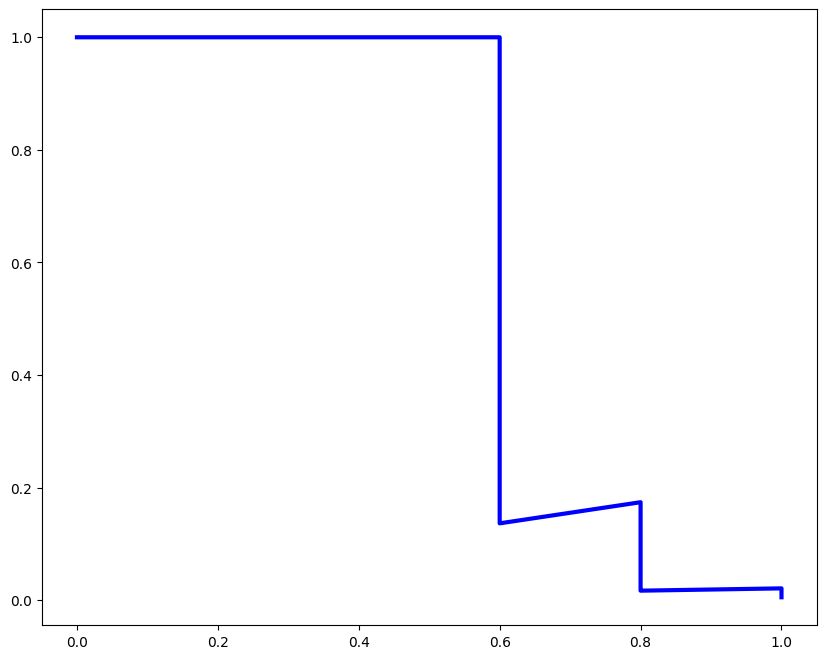

In [15]:
pr_auc = average_precision_score(y_true, y_pred_proba)
plt.figure(figsize=(10, 8))

# Plot PR curve
plt.plot(
    recall, precision,
    color='blue',
    lw=3,
    label=f'Model (PR-AUC = {pr_auc:.4f})'
)

plt.show()

In [ ]:
annotations = np.empty_like(cm, dtype=object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percentage = cm_normalized[i, j] * 100
        annotations[i, j] = f'{count:,}\n({percentage:.2f}%)'
annotations

array([['501\n(50.35%)', '494\n(49.65%)'],
       ['0\n(0.00%)', '5\n(100.00%)']], dtype=object)

In [11]:
f_scores = np.linspace(0.2, 0.9, num=8)
f_scores

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [10]:
data_path = r"C:\Users\jhoni\Documents\LooperAI\repositorios\ml-ai-ops-demos\customer_churn_prediction\data\01-raw\creditcard.csv"


In [ ]:
class FraudDataLoader:
    def __init__(self, data_path, random_state=42):
        self.data_path = data_path
        self.random_state=random_state
        self.scaler = StandardScaler()
    
    def load_data(self) -> pd.DataFrame:
        if not os.path.exists(self.data_path):
            raise FileNotFoundError(f"Dataset not found: {self.data_path}")
        
        df = pd.read_csv(data_path, header=0)
        print(f"Loaded {df.shape[0]} transactions")
        return df
    
    def get_data_stats(self, df) -> Dict:
        stats = {
            "total_transactions": len(df),
            "fraud_count": int(df["Class"].sum()),
            "fraud_rate": float(df["Class"].mean()),
            "legitimate_count": int((df["Class"] == 0).sum()),
            "avg_transaction_amount": float(df["Amount"].mean()),
            "max_transaction_amount": float(df["Amount"].max()),
            "min_transaction_amount": float(df["Amount"].min()),
            "time_span_hours": float((df["Time"].max() - df["Time"].min()) / 3600),
            "features_count": len(df.columns) - 1,  # Exclude target
        }
        
        # Fraud stats
        fraud_df = df[df["Class"]==1]
        stats["avg_fraud_amount"] = float(fraud_df["Amount"].mean()) if len(fraud_df) > 0 else 0
        stats["median_fraud_amount"] = (
            float(fraud_df["Amount"].median()) if len(fraud_df) > 0 else 0
        )
        
        return stats

    def temporal_train_test_split(self, df, train_size:float = 0.6,val_size:float = 0.2, test_size:float = 0.2,):
        """
        CRITICAL: Use temporal split, not random split for fraud detection

        Why: Fraudsters evolve tactics over time. Random split leaks future info.
        """
        df_sorted = df.sort_values("time").reset_index(drop=True)
        
        n = len(df_sorted)
        # Last row in train set
        train_end = int(n*train_size)
        # Last row in validation set
        val_end = int(n * (train_size + val_size))
        
        train_df = df_sorted.iloc[:train_end].copy()
        val_df = df_sorted.iloc[train_end:val_end].copy()
        test_df = df_sorted.iloc[val_end:].copy()
        
        print(f"Train: {len(train_df):,} transactions ({train_df['Class'].sum()} frauds, {train_df['Class'].mean():.4%} fraud rate)")
        print(f"Val:   {len(val_df):,} transactions ({val_df['Class'].sum()} frauds, {val_df['Class'].mean():.4%} fraud rate)")
        print(f"Test:  {len(test_df):,} transactions ({test_df['Class'].sum()} frauds, {test_df['Class'].mean():.4%} fraud rate)")
        
        return train_df, val_df, test_df
    
    def prepare_features(self,train_df,val_df,test_df):
        """
        Prepare features and scale Amount (V1-V28 already scaled via PCA)

        Note: Only Amount needs scaling as V1-V28 are PCA components (already normalized according to source)
        Time is kept for drift detection but excluded from model features
        """
        feature_columns = [col for col in train_df if col not in ["Class", "Time"]]
        
        # Separate features and targets
        X_train = train_df[feature_columns].copy()
        y_train = train_df["Class"].copy()
        
        # Separate features and targets
        X_val = val_df[feature_columns].copy()
        y_val = val_df["Class"].copy()
        
        # Separate features and targets
        X_test = test_df[feature_columns].copy()
        y_test = test_df["Class"].copy()
        
        # Scale Amount only because V1-V28 are PCA components according to source
        X_train_scaled = X_train.copy()
        X_val_scaled = X_val.copy()
        X_test_scaled = X_test.copy()
        
        # Fit scaler only on training data to avoid data leakage
        # This helps to maintain stats values the model learned during training phase
        X_train_scaled['Amount'] = self.scaler.fit_transform(X_train[['Amount']])
        X_val_scaled['Amount'] = self.scaler.transform(X_val[['Amount']])
        X_test_scaled['Amount'] = self.scaler.transform(X_test[['Amount']])
        
    def save_splits(self,train_df,val_df,test_df,output_dir="data/processed/customer_fraud_detection"):
        os.makedirs(output_dir, exist_ok=True)
        
        train_df.to_csv(f"{output_dir}/train_df.csv", index=False)
        val_df.to_csv(f"{output_dir}/val_df.csv", index=False)
        test_df.to_csv(f"{output_dir}/test_df.csv", index=False)
        
        print(f"\nSaved files to {output_dir}")
        
        return {
            'train_path': f'{output_dir}/train.csv',
            'val_path': f'{output_dir}/val.csv',
            'test_path': f'{output_dir}/test.csv'
        }

In [4]:
data_loader = FraudDataLoader(data_path)

In [5]:
df_raw_data = data_loader.load_data()

Loaded 284807 transactions


In [6]:
df_raw_data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
